This script computes distances between every data sample pair in the data set and saves all pairwise distances as a matrix (2D Numpy array). This is later used as the adjacency matrix for the Graph Neural Network (GNN).

The distances supported currently are:
- Dynamic Time Warping (based on the implementation in https://github.com/daochenzha/pydtw)
- Euclidean Distance
- Complexity-Invariant Dissimilarity Measure

In [3]:
import numpy as np
import pandas as pd
import os

1. Change the `dataset_dir` and `dataset_name` to load the data from.
2. Change `output_dir` to the folder where the distance matrix should be saved.
3. Choose the distance metric to be computed and comment the code blocks for the other distances.

In [ ]:
# !!! Load data and compute distances

import sys
 
# adding Folder_2 to the system path
sys.path.insert(0, '/home/vaibhavs/Master_Thesis/ma-vaibhav/Code/SimTSC/pydtw')
import dtw

# Read dataset
dataset_dir = './SimTSC/datasets/EBC'
dataset_name = 'AHU_principal_SUMMER_2023_stanscaler'
output_dir = './SimTSC/tmp'

euc_dir = os.path.join(output_dir, 'ebc_euclidean')
if not os.path.exists(euc_dir):
    os.makedirs(euc_dir)

cid_dir = os.path.join(output_dir, 'ebc_cid')
if not os.path.exists(cid_dir):
    os.makedirs(cid_dir)

dataset_dir = os.path.join(dataset_dir, dataset_name)
df_train = pd.read_csv(os.path.join(dataset_dir, dataset_name+'_TRAIN_ed.tsv'), sep='\t', header=None)
df_test = pd.read_csv(os.path.join(dataset_dir, dataset_name+'_TEST_ed.tsv'), sep='\t', header=None)
df_val = pd.read_csv(os.path.join(dataset_dir, dataset_name+'_VAL_ed.tsv'), sep='\t', header=None)

X_train = df_train.drop(columns=[0]).astype(np.float32)
X_test = df_test.drop(columns=[0]).astype(np.float32)
X_val = df_val.drop(columns=[0]).astype(np.float32)

X_train.columns = range(X_train.shape[1])
X_test.columns = range(X_test.shape[1])
X_val.columns = range(X_val.shape[1])

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
X = np.concatenate((X_train, X_test, X_val), axis=0)

X[np.isnan(X)] = 0
std_ = X.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
X = (X - X.mean(axis=1, keepdims=True)) / std_

X = X.copy(order='C').astype(np.float64)

print(X.shape)

# # calculating DTW distances
# distances = np.zeros((X.shape[0], X.shape[0]), dtype=np.float64)
# for i in range(len(X)):
#     for j in range(len(X)):
#         data = X[i]
#         query = X[j]
#         distances[i][j] = dtw.query(data, query, r=min(len(data)-1, len(query)-1, 100))['value']

# calculating Euclidean distances
distances = np.zeros((X.shape[0], X.shape[0]), dtype=np.float64)
for i in range(len(X)):
    for j in range(len(X)):
        data = X[i]
        query = X[j]
        distances[i][j] = np.linalg.norm(data - query)

# # calculating CID distances
# distances = np.zeros((X.shape[0], X.shape[0]), dtype=np.float64)
# for i in range(len(X)):
#     for j in range(len(X)):
#         data = X[i]
#         query = X[j]
#         CE_Q = np.sqrt(np.sum(np.diff(data, axis=0)**2))
#         CE_C = np.sqrt(np.sum(np.diff(query, axis=0)**2))
#         distances[i][j] = np.sqrt(np.sum((data - query)**2)) * max(CE_Q, CE_C) / min(CE_Q, CE_C)
        
print(distances.shape)
np.save(os.path.join(euc_dir, dataset_name), distances)

(12, 12)


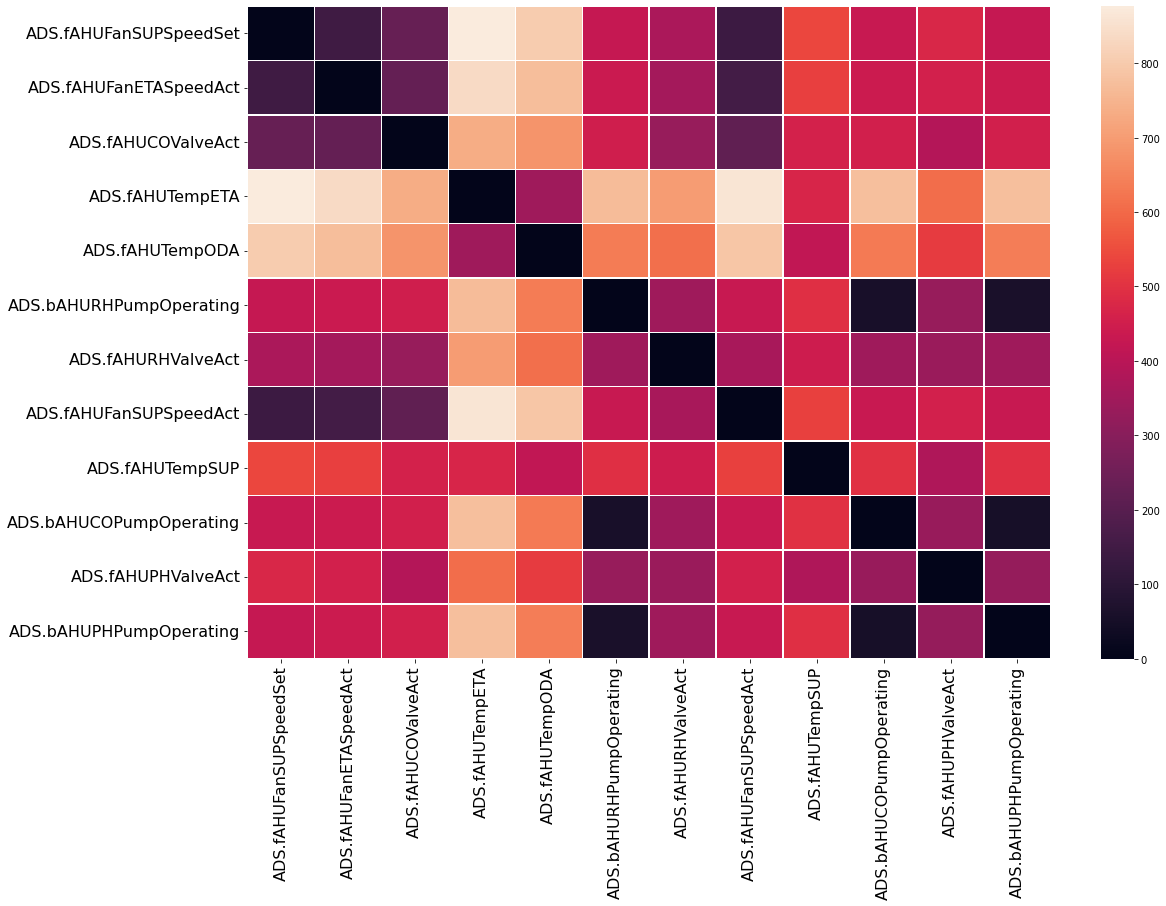

In [4]:
# visualise class-wise Euclidean distances 

from itertools import combinations
import matplotlib.pyplot as plt

# Read dataset
dataset_dir = './SimTSC/datasets/EBC'
dataset_name = '5day_surveyext_Nov22Feb24_stanscaler'
dataset_dir = os.path.join(dataset_dir, dataset_name)
df_train = pd.read_csv(os.path.join(dataset_dir, dataset_name+'_TRAIN.tsv'), sep='\t', header=None)
df_test = pd.read_csv(os.path.join(dataset_dir, dataset_name+'_TEST.tsv'), sep='\t', header=None)
df_val = pd.read_csv(os.path.join(dataset_dir, dataset_name+'_VAL.tsv'), sep='\t', header=None)

Y_train = df_train[df_train.columns[0]].astype(np.str)
Y_test = df_test[df_test.columns[0]].astype(np.str)
Y_val = df_val[df_val.columns[0]].astype(np.str)

Y_train = Y_train.values
Y_test = Y_test.values
Y_val = Y_val.values
Y = np.concatenate((Y_train, Y_test, Y_val), axis=0)

X_train = df_train.drop(columns=[0]).astype(np.float32).values
X_test = df_test.drop(columns=[0]).astype(np.float32).values
X_val = df_val.drop(columns=[0]).astype(np.float32).values

X = np.concatenate((X_train, X_test, X_val), axis=0)

X[np.isnan(X)] = 0
std_ = X.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
X = (X - X.mean(axis=1, keepdims=True)) / std_

X = X.copy(order='C').astype(np.float64)

# Calculate euclidean distances
classes = list(set(Y))
res = list(combinations(classes, 2))
eucs = np.empty([len(classes), len(classes)])
xaxislabels = []
yaxislabels = []

for i_idx in range(len(classes)):
    for j_idx in range(i_idx,len(classes)):
        temp_dist = []
        one_idx = np.asarray(Y == classes[i_idx]).nonzero()[0]
        two_idx = np.asarray(Y == classes[j_idx]).nonzero()[0]
        allvals_1 = []
        allvals_2 = []

        for lidx in one_idx:
            allvals_1.extend(X[lidx].tolist())
        for ridx in two_idx:
            allvals_2.extend(X[ridx].tolist())
        allvals_1 = np.asarray(allvals_1)
        allvals_2 = np.asarray(allvals_2)
        # # euclidean distance
        # dist = np.linalg.norm(allvals_1 - allvals_2)
        # CID distance
        CE_Q = np.sqrt(np.sum(np.diff(allvals_1, axis=0)**2))
        CE_C = np.sqrt(np.sum(np.diff(allvals_2, axis=0)**2))
        dist = np.sqrt(np.sum((allvals_1 - allvals_2)**2)) * max(CE_Q, CE_C) / min(CE_Q, CE_C)
        
        eucs[i_idx, j_idx] = dist
        eucs[j_idx, i_idx] = dist

eucs = np.round(eucs, decimals=2)
print(eucs.shape)

import seaborn as sns
hmap_labels = [s.replace('ADSInternalValuesMirror','') for s in classes]
fig = plt.figure(figsize=(18, 12)) 
ax = sns.heatmap(eucs, linewidth=0.5, xticklabels=hmap_labels, yticklabels=hmap_labels)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.gcf().set_facecolor('white')

plt.savefig('Figures/cid_heatmap-5day_surveyext_Nov22Feb24_stanscaler.png', bbox_inches='tight', dpi=300)

In [5]:
# Euclidean distance

import matplotlib.pyplot as plt

eucs = np.empty([len(classes), len(classes)])
xaxislabels = []
yaxislabels = []

for i_idx in range(len(classes)):
    for j_idx in range(i_idx,len(classes)):
        temp_dist = []
        one_idx = np.asarray(Y == classes[i_idx]).nonzero()[0]
        two_idx = np.asarray(Y == classes[j_idx]).nonzero()[0]
        allvals_1 = []
        allvals_2 = []

        # for lidx in one_idx:
        #     for ridx in two_idx:
        #         dist = np.linalg.norm(X[lidx] - X[ridx])
        #         temp_dist.append(dist)
        # temp_avg = np.mean(temp_dist)
        for lidx in one_idx:
            allvals_1.extend(X[lidx].tolist())
        for ridx in two_idx:
            allvals_2.extend(X[ridx].tolist())
        allvals_1 = np.asarray(allvals_1)
        allvals_2 = np.asarray(allvals_2)
        # norm1 = np.linalg.norm(allvals_1)
        # norm2 = np.linalg.norm(allvals_2)
        # dist = np.linalg.norm((allvals_1/norm1) - (allvals_2/norm2))
        dist = np.linalg.norm(allvals_1 - allvals_2)
        # covar = np.cov(allvals_1,allvals_2)[0][1]
        # dist = 0.5*((np.linalg.norm((allvals_1-np.mean(allvals_1))-(allvals_2-np.mean(allvals_2)))**2) / (np.linalg.norm(allvals_1-np.mean(allvals_1))**2+np.linalg.norm(allvals_2-np.mean(allvals_2))**2))
        
        eucs[i_idx, j_idx] = dist
        eucs[j_idx, i_idx] = dist

eucs = np.round(eucs, decimals=2)
print(eucs.shape)

(12, 12)
